This is a sample code sequence for testing signal processing and data visualization libraries in python. It utilizes fast fourier transforms and signal filtering techniques to showcase scipy code.


The function `butter(N, w_1, btype='low', analog=True, output = 'ba', fs=None)` from the python scipy.signal library represents a low-pass analog Butterworth filter of order $N$ and cutoff frequency $w_1$



In [66]:
#Import necessary libraries

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

I'll start by defining a butterworth filter of order 1 with a cutoff frequency of 1 rad/s. The results `b, a` of the function are the vectors of the numerator and denominator coefficients of the transform, respectively.


In [67]:



N=1
w=1
b, a = signal.butter(N, w, btype='low', analog=True, output = 'ba', fs=None)


Visualization of the frequency response of the normalized filter. The amplitude of the response is approximately -3dB as expected.

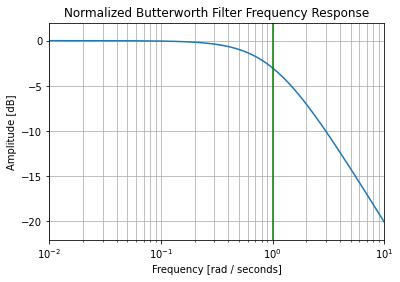

In [68]:

w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Normalized Butterworth Filter Frequency Response')

plt.xlabel('Frequency [rad / seconds]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(1, color='green') # cutoff frequency

plt.show()

Now we need to adapt the filter to build a band-block filter with cutoff frequencies $w_1$ and $w_2$. The ideal transformation for this purpose is:

$$s \leftarrow \frac{1}{Q_{1,2}\cdot \left( \frac{s}{w_{1,2}} + \frac{w_{1,2}}{s}\right)}$$ 
, such that:
$$w_{1,2} = \sqrt{w_1w_2}$$

$$Q_{1,2} = \frac{w_{1,2}}{w_2-w_1}$$

The above transformation was implemented directly in the code so that I didn't have to manually write the vectors that define the numerator and denominator of the band-block filter frequency response function. However, to verify my code, I used a numerical `butter` routine to find the coefficients of the filter specified by the problem. It should be noted that scipy's `butter` function takes its input in radians per second, but the routine I defined takes its input in Hertz. Therefore, adding a $2\pi$ scaling factor was necessary in some parts of the code.


In [69]:
num, den = signal.butter(1, [2*np.pi*40, 2*np.pi*60], btype='bandstop', analog=True, output = 'ba', fs=None)

The deterministic filter is given by:
$$\frac{s^2+9.47482023\cdot10^4}{s^2+1.25663706\cdot10^2 \cdot s +9.47482023\cdot10^4}$$

In [70]:
print(num)
print(den)


[1.00000000e+00 0.00000000e+00 9.47482023e+04]
[1.00000000e+00 1.25663706e+02 9.47482023e+04]


In [71]:


def bandstop_transform(f_1, f_2, freq_array):
  w = freq_array
  epsilon = 1e-8
  f_12 = np.sqrt(f_1*f_2)
  Q = np.divide(f_12, np.absolute(f_2-f_1)+epsilon)
  s = np.reciprocal(Q*(1j*w/f_12 + f_12/(1j*w+epsilon)))
  return s

def normalized_filter(s):

  f_s = np.reciprocal(s+1)
  return f_s

def notch_filtering(freq_array, f_1, f_2, K):
  f_s = K*normalized_filter(bandstop_transform(f_1, f_2, freq_array))
  return f_s



As an example, I set the gain as $K=1$ and the cutoff band as $[40,60]$, but these parameters could hold any value. For testing purposes, I created 2 sample signals at 50 and 500 Hz
:


In [72]:


signal_frequency = 500
noise_frequency = 50
K = 1

t_i = np.arange(0, 0.02, 0.00005)
signal = np.sin(2 * np.pi * signal_frequency * t_i)
noise = np.sin(2 * np.pi * noise_frequency * t_i)

Let's display the signals in the time domain for easy viewing.

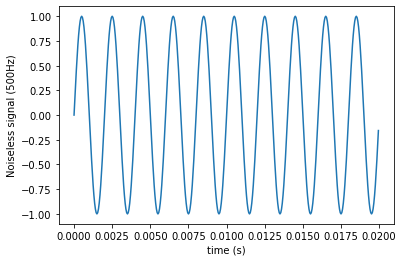

In [73]:
plt.plot(t_i, signal)
plt.xlabel('time (s)')
plt.ylabel('Noiseless signal (500Hz)')
plt.show()

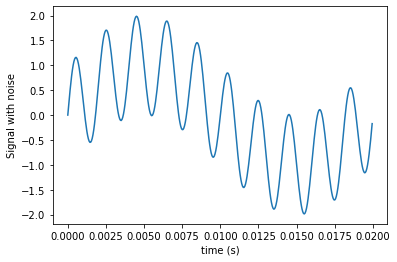

In [74]:
plt.plot(t_i, signal+noise)
plt.xlabel('time (s)')
plt.ylabel('Signal with noise')
plt.show()

Let's show the Fourier transform of the wave shown above:

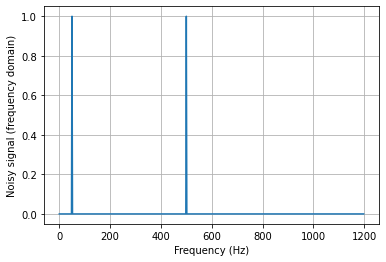

In [75]:


N = 8000

T = 1.0 / 16000.0

t = np.linspace(0.0, N*T, N, endpoint=False)

y = np.sin(signal_frequency* 2.0*np.pi*t) + np.sin(noise_frequency * 2.0*np.pi*t)

yf = fft(y)

xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt

plt.plot(xf[0:600], 2.0/N * np.abs(yf[0:N//2][0:600]))

plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noisy signal (frequency domain)')
plt.show()



Let's show the frequency response function of the Butterworth filter blocks range. It is possible to observe that the local minimum of the function is just before 50Hz, as expected for the sample specifications.

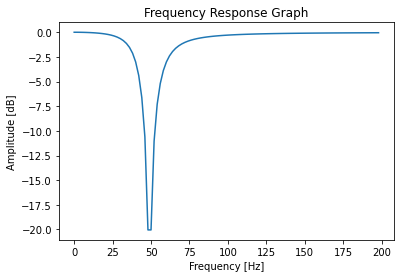

In [76]:
w_low = 40
w_high = 60
#Transference function as implemented above
filtro = notch_filtering(xf, w_low, w_high, K=1)
yf_filtered = yf[0:N//2]*filtro
plt.title('Frequency Response Graph')

plt.xlabel('Frequency [Hz]')

plt.ylabel('Amplitude [dB]')
plt.plot(xf[0:100], 20 * np.log10(np.abs(filtro[0:100])))

Now, the fourier transform of the signal will be visualized after removing the noise frequency.

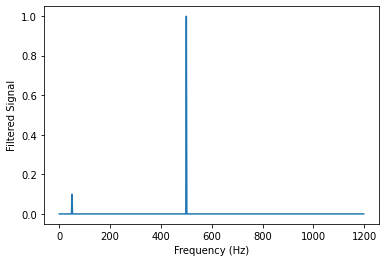

In [77]:

plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered Signal')
plt.plot(xf[:600], 2.0/N * np.abs(yf_filtered)[0:600])
y_iif = yf_filtered/(2*np.pi)

It is clear that the noise has decreased considerably. Let us plot the signal in the time domain after the filtration, through the use of an inverse fourier transform.

In [78]:
sinal_filtr = ifft(y_iif)

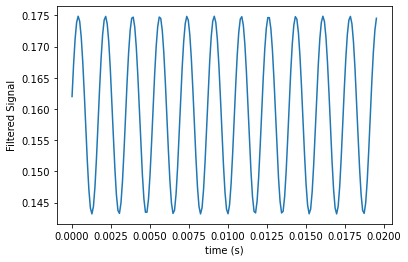

In [79]:
plt.xlabel('time (s)')
plt.ylabel('Filtered Signal')
plt.plot((t[:N//2]*(np.pi/2))[0:200], np.abs(sinal_filtr[0:200]))

We can calculate the S/N ratio of the filter output through the use of the ratio of the filtered fourier transform coefficients.
$$\phi_{ss}=|F(500\text{Hz})|^2$$
$$\phi_{rr}=|F(50\text{Hz})|^2$$  
, where F is the filtered Fourier transform.

The signal to noise ratio is:
$$\frac{\phi_{ss}}{\phi_{rr}}$$
at the filter outlet. 

If we replace the above transform $F(\nu)$ with the transform of the unfiltered signal, we get the signal-to-noise ratio at the filter input.

In [80]:
y_max = max(np.abs(yf_filtered))
index = np.where(abs(yf_filtered)==y_max)
print(index)

(array([250]),)


In [81]:
yf_50 = np.delete(yf_filtered, index)

In [82]:
y50_max = max(abs(yf_50))

In [83]:
snr_raw = y_max/y50_max

In [84]:
print(snr_raw**2) #signal to noise ratio as calculated per deterministic correlation formula above

100.83552051152391


In [85]:
y_max = max(np.abs(yf))
index = np.where(abs(yf)==y_max)
print(index)
yf_50 = np.delete(yf, index)

(array([  25, 7975]),)


In [86]:
y50_max = max(abs(yf_50))

In [87]:
print(y_max/y50_max)


1.0000000000000004


The signal-to-noise ratio of the original signal, in which the two sinusoids (noise and signal) were set to the same amplitude, is close to 1. The signal-to-noise ratio of the filtered signal was around 100.836.
